In [0]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6864-hw2b

In [0]:
import os
os.makedirs("6864-hw2b", exist_ok=True)
import sys
sys.path.append("/content/6864-hw2b")

In [4]:
!pip install sacrebleu

     |████████████████████████████████| 61kB 1.1MB/s 
     |████████████████████████████████| 17.1MB 199kB/s 


# **Part 3 Encoder-Decoder Model**



In this lab, you will explore seq2seq with and without attention to perform machine translation task. The main task is to implement the naive encoder-decoder architecture. The dataset we used here is IWSLT'15 English-Vietnamese translation data. 

To complete this lab, you need to first understand the recurrent update mechanism and the attention mechanism introduced in lecture, and transform them into PyTorch code.

In machine translation task(MT), your goal is to translate the correct sentence meaning into another language. Here in our case, we want to translate English sentences into Vietnamese sentences.

First, we want to download the dataset.

In [5]:
# Download data
!wget -nv -O /content/6864-hw2b/train.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O /content/6864-hw2b/train.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O /content/6864-hw2b/tst2013.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O /content/6864-hw2b/tst2013.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O /content/6864-hw2b/vocab.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O /content/6864-hw2b/vocab.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

2020-04-12 01:51:06 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en [13603614/13603614] -> "/content/6864-hw2b/train.en" [1]
2020-04-12 01:51:22 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi [18074646/18074646] -> "/content/6864-hw2b/train.vi" [1]
2020-04-12 01:51:26 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en [132264/132264] -> "/content/6864-hw2b/tst2013.en" [1]
2020-04-12 01:51:29 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi [183855/183855] -> "/content/6864-hw2b/tst2013.vi" [1]
2020-04-12 01:51:32 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/6864-hw2b/vocab.en" [1]
2020-04-12 01:51:35 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi [46767/46767] -> "/content/6864-hw2b/vocab.vi" [1]


Here we're going to load the data.

In [0]:
def read_sentence_file(filename):
  sentences_list = []
  with open(filename, "r") as f:
    for line in f:
      sentences_list.append(line.strip().split())
  return sentences_list

def read_vocab_file(filename):
  with open(filename, "r") as f:
    return [line.strip() for line in f]


src_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.vi"))
trg_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.en"))

train_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.vi"))
train_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.vi"))
test_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

Next, we do preprocessing on the dataset and did a preliminary data analysis.

Number of training (src, trg) sentence pairs: 108748
Number of validation (src, trg) sentence pairs: 12083
Number of testing (src, trg) sentence pairs: 1139
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17192
Training sentence avg. length: 20 
Training sentence length at 95-percentile: 42
Training sentence length distribution (x-axis is length range and y-axis is count):



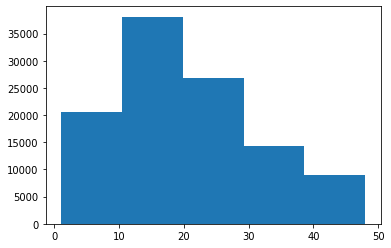

Example Vietnamese input: ['Adam', 'Sadowsky', 'dàn', 'dựng', '1', 'video', 'âm', 'nhạc', 'hiện', 'tượng', '.']
Its target English output: ['Adam', 'Sadowsky', ':', 'How', 'to', 'engineer', 'a', 'viral', 'music', 'video']


In [7]:
import numpy as np
import matplotlib.pyplot as plt


MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

# We only keep sentences that do not exceed 48 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 50 words.
def filter_data(src_sentences_list, trg_sentences_list, max_len):
  new_src_sentences_list, new_trg_sentences_list = [], []
  for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
    if (len(src_sent) <= max_len and len(trg_sent) <= max_len
        and len(src_sent) > 0 and len(trg_sent)) > 0:
      new_src_sentences_list.append(src_sent)
      new_trg_sentences_list.append(trg_sent)
  return new_src_sentences_list, new_trg_sentences_list

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, max_len=MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, max_len=MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))
src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[0]))
print('Its target English output: ' + str(train_trg_sentences_list[0]))

Define the regular torch hyperparameters.

In [0]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Load MT dataset into the dataset class. We will apply the dataloader function in pytorch to sample our data later.

In [0]:
from torch.utils import data


# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## Encoder

We will start with a single-layer unidirectional GRU. You are free to try bidirectional and stack more layers.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    super(Encoder, self).__init__()
    self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True,
                      dropout=dropout, bidirectional=False)

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
      Hint: `outputs` and `finals` are both standard GRU outputs. Check:
      https://pytorch.org/docs/stable/nn.html#gru
    """
    packed = pack_padded_sequence(inputs, lengths, batch_first=True,
                                  enforce_sorted=False)
    outputs, finals = self.rnn(packed) #outputs[128,50,256], finals[1, 128, 256]
    outputs, _ = pad_packed_sequence(outputs, batch_first=True,
                                     total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    return outputs, finals

In [0]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True,
                      dropout=dropout)

    # To initialize from the final encoder state.
    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + input_size, hidden_size,
                                      bias=False)

  def forward_step(self, prev_embed, hidden):
    """Perform a single decoder step (1 word)."""

    # Update RNN hidden state.
    output, hidden = self.rnn(prev_embed, hidden)

    pre_output = torch.cat([prev_embed, output], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return output, hidden, pre_output
    
  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    # Here we store all intermediate hidden states and pre-output vectors.
    decoder_states = []
    pre_output_vectors = []

    # Unroll the decoder RNN for `max_len` steps.
    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1) #[128,1,256]
      output, hidden, pre_output = self.forward_step(prev_embed, hidden)
      decoder_states.append(output)
      pre_output_vectors.append(pre_output)

    decoder_states = torch.cat(decoder_states, dim=1)
    pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
    return hidden, pre_output_vectors

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    #decoder_init_hiddens [1,128,256]
    return decoder_init_hiddens

Define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

In [0]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens
    return self.decode(encoder_finals, trg_ids[:, :-1])
    #trg_ids[:,:-1] (128,49)

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)
    #trg_embed(trg_ids) (128,49,256)

In [42]:
src_embed=nn.Embedding(len(src_vocab_set), 256)
trg_embed=nn.Embedding(len(trg_vocab_set), 256)

src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B = next(iter(train_data_loader))
print(len(train_data_loader))
print(trg_ids_BxL.size())

print("input size:",trg_embed(trg_ids_BxL[:,:-1]).size())
inputs = trg_embed(trg_ids_BxL[:,:-1])
prev_embed = inputs[:, 1].unsqueeze(0).size()
print(prev_embed)


850
torch.Size([128, 50])
input size: torch.Size([128, 49, 256])
torch.Size([128, 1, 256])


It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [0]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

### Attention-based Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 


In [0]:
class AttentionDecoder(nn.Module):
  """An attention-based RNN decoder."""

  def __init__(self, input_size, hidden_size, attention, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(AttentionDecoder, self).__init__()

    self.attention = attention

    self.rnn = nn.GRU(input_size + hidden_size, hidden_size, batch_first=True,
                      dropout=dropout)

    # To initialize from the final encoder state.
    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + hidden_size + input_size,
                                      hidden_size, bias=False)

  def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key,
                   hidden):
    """Perform a single decoder step (1 word)"""

    # Compute context vector using attention mechanism.
    query = hidden[-1].unsqueeze(1)

    context, attn_probs = self.attention(query=query, proj_key=proj_key,
                                         value=encoder_hidden, mask=src_mask)

    # Update RNN hidden state.
    rnn_input = torch.cat([prev_embed, context], dim=2)
    output, hidden = self.rnn(rnn_input, hidden)

    pre_output = torch.cat([prev_embed, output, context], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return output, hidden, pre_output
    
  def forward(self, inputs, encoder_hiddens, encoder_finals,  src_mask,
              trg_mask, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.
    
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_hiddens`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the encoder
          outputs for each decoding step to attend to. 
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `src_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for source sentences.
      - `trg_mask`: a 3d-tensor of shape (batch_size, 1, max_seq_length)
          representing the mask for target sentences.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: (same as in Decoder) a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = trg_mask.size(-1)

    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    # Pre-compute projected encoder hidden states (the "keys" for the attention
    # mechanism). This is only done for efficiency.
    proj_key = self.attention.key_layer(encoder_hiddens)

    # Here we store all intermediate hidden states and pre-output vectors.
    decoder_states = []
    pre_output_vectors = []

    # Unroll the decoder RNN for `max_len` steps.
    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1)
      output, hidden, pre_output = self.forward_step(prev_embed,
                                                     encoder_hiddens, src_mask,
                                                     proj_key, hidden)
      decoder_states.append(output)
      pre_output_vectors.append(pre_output)

    decoder_states = torch.cat(decoder_states, dim=1)
    pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
    return hidden, pre_output_vectors

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    return decoder_init_hiddens

In [0]:
class EncoderAttentionDecoder(nn.Module):
  """A Encoder-Decoder architecture with attention.
  """
  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `AttentionDecoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and tar get sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    trg_mask = (trg_ids[:, 1:] != PAD_INDEX).unsqueeze(-2)
    return self.decode(encoder_hiddens, encoder_finals, src_mask,
                       trg_ids[:, :-1], trg_mask)

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)

  def decode(self, encoder_hiddens, encoder_finals, src_mask, trg_ids,
             trg_mask, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_hiddens,
                        encoder_finals, src_mask, trg_mask, decoder_hidden)

### Attention                     

Attention layer plays a key role in seq2seq models. It allows for capturing the dependencies without the distance constraints in the input or output sequences. In this lab, your goal is to implement the Bahdanau attention mechanisms. 

In [0]:
class BahdanauAttention(nn.Module):
  """Implements Bahdanau (MLP) attention."""

  def __init__(self, hidden_size, key_size=None, query_size=None):
    super(BahdanauAttention, self).__init__()

    key_size = hidden_size if key_size is None else key_size
    query_size = hidden_size if query_size is None else query_size

    self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
    self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
    self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

    # To store attention scores.
    self.alphas = None
        
  def forward(self, query=None, proj_key=None, value=None, mask=None):
    assert mask is not None, "mask is required"

    # We first project the query (the decoder state).
    # The projected keys (the encoder states) were already pre-computated.
    query = self.query_layer(query)

    # Calculate scores.
    scores = self.energy_layer(torch.tanh(query + proj_key))
    scores = scores.squeeze(2).unsqueeze(1)

    # Mask out invalid positions.
    # The mask marks valid positions so we invert it using `mask & 0`.
    scores.data.masked_fill_(mask == 0, -float('inf'))

    # Turn scores to probabilities.
    alphas = F.softmax(scores, dim=-1)
    self.alphas = alphas        

    # The context vector is the weighted sum of the values.
    context = torch.bmm(alphas, value)

    # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
    return context, alphas

Apply the dataloader to the MT dataset. Dataloader provides a convenient way to iterate through the whole dataset.

In [0]:
batch_size = 128

# You can try on a smaller training set by setting a smaller `sampling`.
train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
                                  shuffle=False)

The main functions for training, here we use perplexity to evaluate the performance of the model.

Although we provide the training scripts here, we strongly encoureage you to go through and understand the procedure.

In [0]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)
    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)

    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

The main function to perform training.

In [15]:
# Hyperparameters for contructing the encoder-decoder model.

embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=Decoder(embed_size, hidden_size, dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                      print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
Epoch Step: 0 Loss: 164.283936
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])
encoder_finals torch.Size([1, 128, 256])
initialized encoder_finals torch.Size([1, 128, 256])
finals size torch.Size([1, 128, 256])

KeyboardInterrupt: ignored

Plot the perplexity graph.

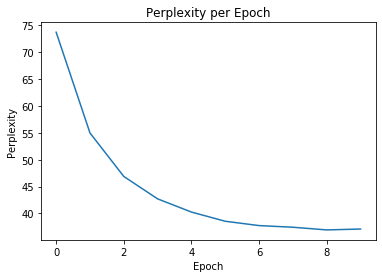

In [0]:
def plot_perplexity(perplexities):
  """plot perplexities"""
  plt.title("Perplexity per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Perplexity")
  plt.plot(perplexities)

plot_perplexity(pure_dev_ppls)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch Step: 0 Loss: 180.053177
Epoch Step: 100 Loss: 95.803543
Epoch Step: 200 Loss: 88.990448
Epoch Step: 300 Loss: 73.352814
Epoch Step: 400 Loss: 74.548058
Epoch Step: 500 Loss: 67.995300
Epoch Step: 600 Loss: 68.646118
Epoch Step: 700 Loss: 69.664398
Epoch Step: 800 Loss: 66.449677
Validation perplexity: 32.856711
Epoch 1
Epoch Step: 0 Loss: 61.769150
Epoch Step: 100 Loss: 58.377026
Epoch Step: 200 Loss: 55.020344
Epoch Step: 300 Loss: 56.482159
Epoch Step: 400 Loss: 57.452576
Epoch Step: 500 Loss: 61.371292
Epoch Step: 600 Loss: 57.677532
Epoch Step: 700 Loss: 55.710712
Epoch Step: 800 Loss: 54.746990
Validation perplexity: 20.907627
Epoch 2
Epoch Step: 0 Loss: 51.143478
Epoch Step: 100 Loss: 47.702641
Epoch Step: 200 Loss: 49.896042
Epoch Step: 300 Loss: 50.827049
Epoch Step: 400 Loss: 48.907604
Epoch Step: 500 Loss: 47.258926
Epoch Step: 600 Loss: 46.769863
Epoch Step: 700 Loss: 49.825222
Epoch Step: 800 Loss: 42.675018
Validation perplexity: 17.617843
Epoch 3
Epoch Step: 0 Loss

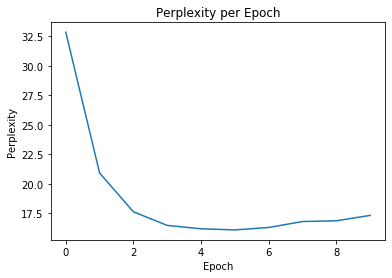

In [0]:
attn_seq2seq = EncoderAttentionDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=AttentionDecoder(embed_size, hidden_size,
                  attention=BahdanauAttention(hidden_size), dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

attn_dev_ppls = train(attn_seq2seq, num_epochs=10, learning_rate=1e-3,
                      print_every=100)

plot_perplexity(attn_dev_ppls)

In [0]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output


def greedy_decode_attention(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderAttentionDecoder."""

  with torch.no_grad():
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    trg_mask = torch.ones_like(prev_y)

  output = []
  attention_scores = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_hiddens, encoder_finals, src_mask,
                                     prev_y, trg_mask, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).fill_(next_word).type_as(src_ids)
    attention_scores.append(model.decoder.attention.alphas.cpu().numpy())

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab):
  return [vocab[i] for i in x]

In [0]:
def print_examples(model, data_loader, n=3,
                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, 
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=max_len)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=max_len)
    else:
      raise NotImplementedError("Unknown model type.")

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
    print()

    if i == n - 1:
      break

In [0]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print_examples(pure_seq2seq, example_data_loader)

Example #1
Src :  Khoa học đằng sau một tiêu đề về khí hậu
Trg :  Rachel <unk> : The science behind a climate headline
Pred:  Science has to solve climate crisis .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred:  I want to tell you what scientists have to do with the most amazing thing about the <unk> of the world .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Trg :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Pred:  There are these things that are going to happen in the air , and if you &apos;re going to be <unk> , it &apos;s not like the <unk

In [0]:
import sacrebleu
from tqdm import tqdm


def compute_BLEU(model, data_loader):
  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    else:
      raise NotImplementedError("Unknown model type.")

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab_set))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score


test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print(np.mean(compute_BLEU(pure_seq2seq, test_data_loader)))  # BLEU: 5.8
print(np.mean(compute_BLEU(attn_seq2seq, test_data_loader)))  # BLEU: 14.9

  0%|          | 0/1139 [00:00<?, ?it/s]

5.882031050834033


100%|██████████| 1139/1139 [01:42<00:00, 11.59it/s]

14.905515370641666


## **Part 3: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. In this lab we use greedy search for decoding, that is, always taking the most likely word at each timestep as prediction. Describe an alternative decoding method that might work better than greedy search. You don't have to implement it.

2. Pick some samples and visualize their attention maps. Discuss your findings. Hint: compute the attention scores on the input words for each timestep when you perform decoding.

3. Compare the performance of seq2seq with and without attention on sentences of different lengths. You can set some length intervals (e.g., 1-10, 11-20, 21-30, 31-40, 41-50) and compare the two models's BLEU scores within each length interval. Discuss your findings.

4. Try to improve your BLEU score on test set. For example, try stacking more RNN layers, switching cell types, or applying bi-direction to encoder. Hints:
  * TA's preliminary implemtation of seq2seq with attention model achieves around 16. You don't have to surpass it (although it's pretty simple to do so)--this number is just to give you some sense of a baseline.
  * Training on the entire training set takes some time. So tune your hyperparameters on a smaller training set (you can do so by changing `sampling` when creating the data loader). Most of the time the performance transfer to large data.